# Evaluate Pre-Trained Models on the Tripod Test Split

Used to generate figures and show how IoU degrades with time..

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [1]:
# Check if notebook is running in Colab or local workstation
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[1]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm() 

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 10000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 65.2 GB  | Proc size: 54.0 MB
GPU RAM Free: 11176MB | Used: 2MB | Util   0% | Total 11178MB

GPU memory is sufficient to proceeed.


In [2]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    
    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')
    
    # clone repo, install packages not installed by default
    !pip install pydensecrf

In [3]:
import os
import os.path as osp

import glob

# for manually reading high resolution images
import cv2
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# pytorch core library
import torch
# pytorch neural network functions
from torch import nn
# pytorch dataloader
from torch.utils.data import DataLoader

# for post-processing model predictions by conditional random field 
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

from tqdm import tqdm  # progress bar

# evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports (files provided by this repo)
import transforms as T

# various helper functions, metrics that can be evaluated on the GPU
from task_3_utils import evaluate, evaluate_loss, eval_binary_iou, pretty_image, img_to_nchw_tensor

# Custom dataloader for rapidly loading images from a single LMDB file
from folder2lmdb import VOCSegmentationLMDB

In [4]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

The architecture is fully-convolutional network (FCN) 8s.

In [ ]:
from fcn import FCN8s
net = FCN8s(n_class=1).to(device)

In [ ]:
from apex import amp
net = amp.initialize(net, opt_level='O3')

In [ ]:
if IN_COLAB:
    root = osp.join(DATA_PATH, 'Checkpoints/fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1')
else:
    #root = '/scratch/gallowaa/cciw/logs/v1.0.1-debug/fcn8s/lr1e-03/wd5e-04/bs25/ep80/seed4/checkpoint' # b
    #root = '/scratch/gallowaa/cciw/logs/v111/trainval/fcn8s/lr1e-03/wd5e-04/bs40/ep80/seed2/checkpoint/' # d
    root = osp.join(
        #os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/fcn8slim/lr5e-03/wd5e-04/bs40/ep80/seed1/checkpoint')
        os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint')

#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed4_epoch70.ckpt' # b
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs40_ep80_seed2amp_epoch79.pt' # d
ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt'
#ckpt_file = 'fcn8slim_lr5e-03_wd5e-04_bs40_ep80_seed1_epoch79.ckpt'

"""Feel free to try these other checkpoints later after running epoch40 to get a 
feel for how the evaluation metrics change when model isn't trained as long."""

checkpoint = torch.load(osp.join(root, ckpt_file))
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')

net = checkpoint['net']
# AMP
#net.load_state_dict(checkpoint['net'])
#amp.load_state_dict(checkpoint['amp'])

last_epoch = checkpoint['epoch'] + 1
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print('Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

net.eval()

In [ ]:
#net = amp.initialize(net, opt_level='O3')

In [ ]:
sig = nn.Sigmoid()  # initializes a sigmoid function

In [5]:
os.environ['DATA_PATH'] = '/scratch/gallowaa/'

if IN_COLAB:
    root = osp.join(
        DATA_PATH, 'Checkpoints/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1')
    
else:
    root = osp.join(
        os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint')

ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt'

model_to_load = osp.join(root, ckpt_file)
                         
print('Loading', model_to_load)                         
         
checkpoint = torch.load(model_to_load)
                        
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')
net = checkpoint['net']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print(
    'Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

sig = nn.Sigmoid()  # initializes a sigmoid function

net.eval()

Loading /scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt
==> Resuming from checkpoint..
Loaded model deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79 trained to epoch  79
Cross-entropy loss 0.1614 for train set, 0.9776 for validation set


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## 7. i) Visualize Predictions on Whole Images

Here we manually load and preprocess the original images and png masks using OpenCV.

`root_path` -- will also be used in 

In [6]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/Test/Lab/')
else:
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Tripod/1354/'

jpeg_files = glob.glob(root_path + '*.jpg')
png_files = glob.glob(root_path + '*_final.png')

jpeg_files.sort()
png_files.sort()

# Note: there is only one segmentation mask (PNG file) per Tripod site
print(len(jpeg_files)) 
print(len(png_files))

7
1


In [7]:
#jpeg_files

In [8]:
"""Set to True to save the model predictions in PNG format, 
otherwise proceed to predict biomass without saving images"""
SAVE_PREDICTIONS = True

if SAVE_PREDICTIONS:
    prediction_path = ''
    for t in root.split('/')[:-1]:
        prediction_path += t + '/'

    prediction_path = osp.join(prediction_path, 'predictions-tripod')

    if not osp.exists(prediction_path):
        os.mkdir(prediction_path)
        
    print(prediction_path)

    # src is the training dataset, tgt is the testing dataset
    src = 'train_v120'
    tgt = 'Tripod'

/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/predictions-tripod


In [9]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

# LOM: Figure 5 (Tripod images)

torch.Size([3000, 4000])
0.14925482869148254
/scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/predictions-tripod/train_v120-Tripod__Lab_1354_2019-05-24_GoPro-1__deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79_scale100_iou_0.149


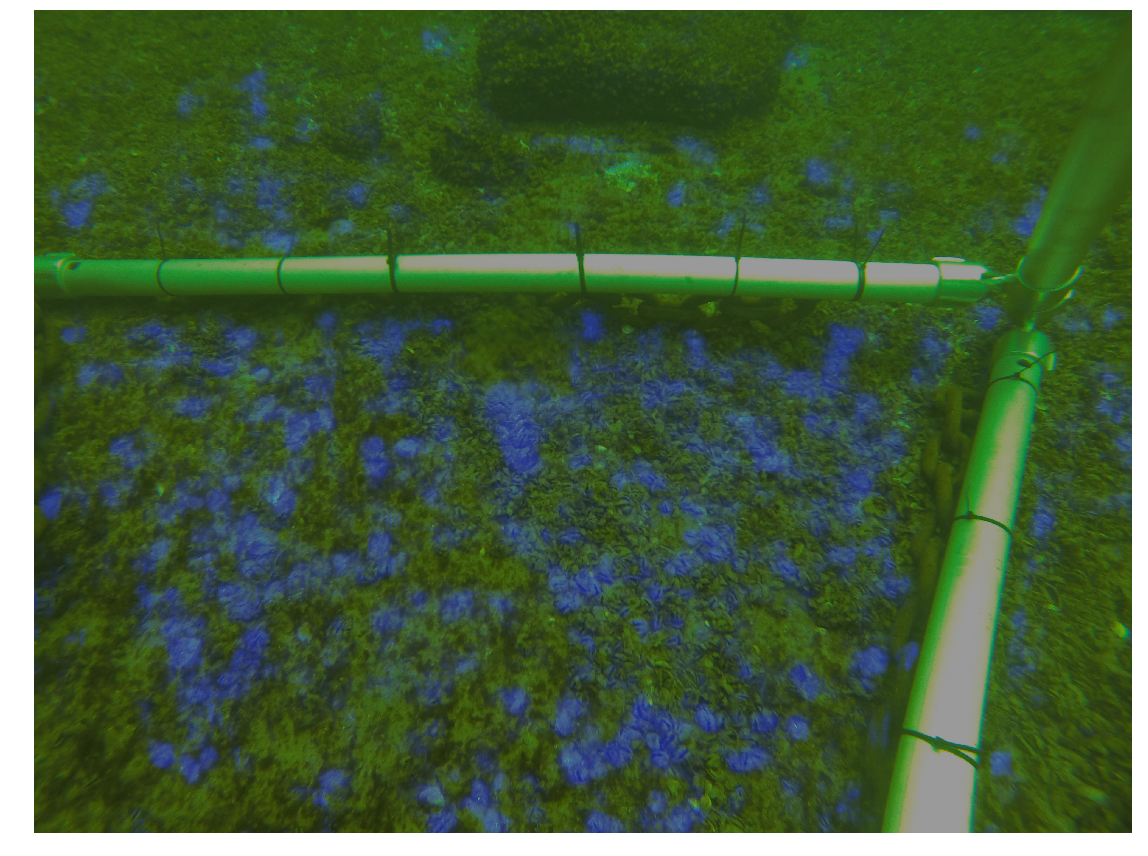

In [15]:
# load mask
bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))

# load specific image
i = 1

image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))

imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

scale_percent = 100
width = int(imgc.shape[1] * scale_percent / 100)
height = int(imgc.shape[0] * scale_percent / 100)
imgc = cv2.resize(imgc, (width, height)) # resize image
labc = cv2.resize(labc, (width, height)) # resize image

nchw_tensor = img_to_nchw_tensor(imgc, device)

with torch.no_grad():
    pred = sig(net(nchw_tensor)['out'])

pred_np = pred.detach().cpu().numpy()
pred_np = pred_np.squeeze()

mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
#jaccard_fcn = jsc(pred_np.round().reshape(-1, 1), mask.reshape(-1, 1))
#print('Image %d of %d, IoU %.4f' % (i, len(val_mask), jaccard_fcn))

targets = torch.LongTensor(mask)
targets = targets.to(device)
print(targets.shape)
iou = eval_binary_iou(pred, targets).item()
print(iou)

p = (pred_np * 255).astype('uint8')
src2 = np.zeros(
    (p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(imgc, 0.6, src2, 0.5, 0.5)
fig = plt.figure(figsize=(16, 12))
plt.imshow(dst)
plt.axis('off')
plt.tight_layout()

filename = src + '-' + tgt + '__' + image_stem + '__' + model_stem  + '_scale%d_iou_%.3f' % (scale_percent, iou)
out_file = osp.join(prediction_path, filename)
fig.savefig(out_file + '.jpg', format='jpeg')
print(out_file)

In [ ]:
w_y = 1500
w_x = 2000
scale_percent = 150

bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))

labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

i = 3
image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
composite_image = np.zeros((bgr_lab.shape[0], bgr_lab.shape[1]))

for row in range(bgr_img.shape[0] // w_y):    
    for col in range(bgr_img.shape[1] // w_x):

        top = w_y * row
        bot = w_y * (row + 1)
        left  = w_x * col
        right = w_x * (col + 1)

        img = imgc[top:bot, left:right, :]
        lab = labc[top:bot, left:right]

        width = int(img.shape[0] * scale_percent / 100)
        height = int(img.shape[1] * scale_percent / 100)
        img = cv2.resize(img, (width, height)) # resize image
        lab = cv2.resize(lab, (width, height)) # resize image

        nchw_tensor = img_to_nchw_tensor(img, device)

        with torch.no_grad():
            pred = sig(net(nchw_tensor)['out'])
        pred_np = pred.detach().cpu().numpy()

        # OpenCV loads the PNG mask as indexed color RGB, 
        # we need to convert it to a binary mask. 
        # The `0' in labc[:, :, 0] is the R channel.
        mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
        mask[lab[:, :, 0] == 128] = 1

        pred_np = pred_np.squeeze()        
        width = int(img.shape[0] * 100 / scale_percent)
        height = int(img.shape[1] * 100 / scale_percent)
        pred_np_native = cv2.resize(pred_np, (width, height)) # resize image
        composite_image[top:bot, left:right] = pred_np_native * 255

pred = torch.FloatTensor((composite_image / 255)).to(device)
mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1

targets = torch.LongTensor(mask)
targets = targets.to(device)

outputs = pred.squeeze(1).round().long()
intersection = (outputs & targets).float().sum((0, 1))
union = (outputs | targets).float().sum((0, 1))
iou = intersection / union
print(iou.item())

In [ ]:
#p = (pred_np * 255).astype('uint8')
p = composite_image.astype('uint8')

src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(imgc, 0.6, src2, 0.5, 0.5)
fig = plt.figure(figsize=(16, 12))
plt.imshow(dst)
plt.axis('off')
plt.tight_layout()

# Biofouling figure

In [ ]:
bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))

iou_list = []

for i in range(len(jpeg_files)):
    image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
    imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img = imgc.copy()

    nchw_tensor = img_to_nchw_tensor(imgc, device)

    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])

    pred_np = pred.detach().cpu().numpy()

    # OpenCV loads the PNG mask as indexed color RGB, 
    # we need to convert it to a binary mask. 
    # The `0' in labc[:, :, 0] is the R channel.
    mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
    mask[labc[:, :, 0] == 128] = 1

    pred_np = pred_np.squeeze()

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
    #jaccard_fcn = jsc(pred_np.round().reshape(-1, 1), mask.reshape(-1, 1))
    #print('Image %d of %d, IoU %.4f' % (i, len(val_mask), jaccard_fcn))

    targets = torch.LongTensor(mask)
    targets = targets.to(device)
    print(targets.shape)
    iou = eval_binary_iou(pred, targets).item()
    print(iou)
    iou_list.append(iou)

In [ ]:
np.save('npy/Tripod_' + image_stem[4:] + '_biofouling_' + model_stem + '.npy', np.asarray(iou_list))

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
p = (pred_np * 255).astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(img, 0.5, src2, 0.5, 0)
axes.imshow(dst)
#axes.imshow(img)
axes.axis('off')

plt.tight_layout()

if SAVE_PREDICTIONS:
    filename = src + '-' + tgt + '__' + image_stem + '__' + model_stem + '_iou_%.4f' % iou
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.jpg', format='jpeg')

# Split up image into smaller chunks

In [ ]:
#i = 1

iou_zoom_list = []

w_y = 1500
w_x = 2000
scale_percent = 150

bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))

labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)

for i in range(len(jpeg_files)):

    image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    composite_image = np.zeros((bgr_lab.shape[0], bgr_lab.shape[1]))

    for row in range(bgr_img.shape[0] // w_y):    
        for col in range(bgr_img.shape[1] // w_x):

            top = w_y * row
            bot = w_y * (row + 1)
            left  = w_x * col
            right = w_x * (col + 1)

            img = imgc[top:bot, left:right, :]
            lab = labc[top:bot, left:right]

            width = int(img.shape[0] * scale_percent / 100)
            height = int(img.shape[1] * scale_percent / 100)
            img = cv2.resize(img, (width, height)) # resize image
            lab = cv2.resize(lab, (width, height)) # resize image

            nchw_tensor = img_to_nchw_tensor(img, device)

            with torch.no_grad():
                pred = sig(net(nchw_tensor)['out'])
            pred_np = pred.detach().cpu().numpy()

            # OpenCV loads the PNG mask as indexed color RGB, 
            # we need to convert it to a binary mask. 
            # The `0' in labc[:, :, 0] is the R channel.
            mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
            mask[lab[:, :, 0] == 128] = 1

            pred_np = pred_np.squeeze()        
            width = int(img.shape[0] * 100 / scale_percent)
            height = int(img.shape[1] * 100 / scale_percent)
            pred_np_native = cv2.resize(pred_np, (width, height)) # resize image
            composite_image[top:bot, left:right] = pred_np_native * 255

    pred = torch.FloatTensor((composite_image / 255)).to(device)
    mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
    mask[labc[:, :, 0] == 128] = 1

    targets = torch.LongTensor(mask)
    targets = targets.to(device)

    outputs = pred.squeeze(1).round().long()
    intersection = (outputs & targets).float().sum((0, 1))
    union = (outputs | targets).float().sum((0, 1))
    iou = intersection / union
    print(iou.item())
    iou_zoom_list.append(iou)

In [ ]:
np.save('npy/Tripod_zoom' + str(scale_percent) + '_' + image_stem[4:] + '_biofouling_' + model_stem + '.npy', np.asarray(iou_zoom_list))

In [ ]:
#plt.figure(figsize=(20, 15))
#plt.imshow(composite_image)

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
#p = (pred_np * 255).astype('uint8')
p = composite_image.astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(imgc, 0.5, src2, 0.5, 0)
axes.imshow(dst)
axes.axis('off')
plt.tight_layout()

if SAVE_PREDICTIONS:
    filename = src + '-' + tgt + '__composite' + image_stem + '__' + model_stem + '_iou_%.4f' % iou
    out_file = osp.join(prediction_path, filename)
    fig.savefig(out_file + '.jpg', format='jpeg')

In [ ]:
pred = torch.FloatTensor((composite_image / 255)).to(device)

In [ ]:
mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1

targets = torch.LongTensor(mask)
targets = targets.to(device)

outputs = pred.squeeze(1).round().long()
intersection = (outputs & targets).float().sum((0, 1))
union = (outputs | targets).float().sum((0, 1))
iou = intersection / union
print(iou.item())

In [ ]:
#plt.imshow(img)

In [ ]:
prediction_path

In [ ]:
#dst.shape